In [25]:
import json
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored

from data_loading import load_tlc_samples
from models import Match, SampleCollection
from config import TLCPaths

In [26]:
def show_search_score_proportion(matches):
    nums_matched = []
    x = np.linspace(0, 1, 10)
    for threshold in x:
        num_matched = len([match for match in matches if match.match['score'] > threshold])
        nums_matched.append(num_matched / len(matches))

    fig, ax = plt.subplots()
    ax.plot(x, nums_matched)
    ax.set_xlabel("score threshold")
    ax.set_ylabel("% matched")
    ax.grid()
    plt.show()


In [27]:
for file in TLCPaths.project_data_path.iterdir():
    if "matched_solr" in str(file.name):
        print(file.name)

matched_solr_TIME.json
not_matched_solr_TIME.json


In [28]:
matched_file_path = TLCPaths.project_data_path.joinpath("matched_solr_TIME.json")
not_matched_file_path = TLCPaths.project_data_path.joinpath("not_matched_solr_TIME.json")
# load the two json files 
with open(matched_file_path, "r") as f:
    matched = [Match.parse_raw(x) for x in json.load(f)]
with open(not_matched_file_path, "r") as f:
    not_matched = [Match.parse_raw(x) for x in json.load(f)]

In [29]:
print(f"{len(matched)=}")
print(f"{len(not_matched)=}")


len(matched)=7390
len(not_matched)=0


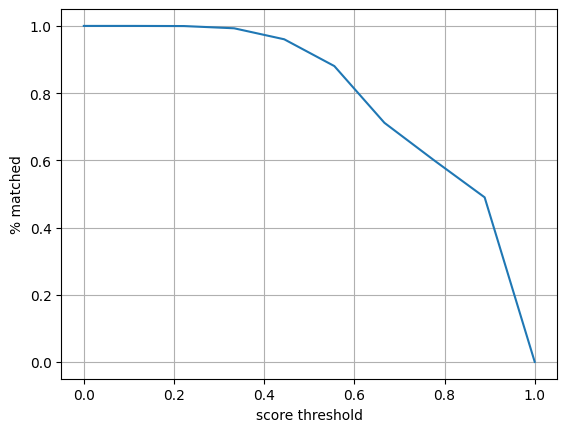

In [30]:
show_search_score_proportion(matched)

In [31]:
def print_n_matches(matches, n=10):
    for matched_item in random.sample(matches, n):
        annotation = matched_item.mention.annotation
        synonyms_from_tlc = matched_item.mention.stems
        # original_mention = annotation.get_mention()
        matched_string = matched_item.matched_string if matched_item.matched_string else synonyms_from_tlc
        print(matched_string, " matched with ", matched_item.match['index_term'],
              f"(score = {matched_item.match['score']})")
        print()


print_n_matches(matched)

spieglung  matched with  ['spiegelung'] (score = 0.9)

hirnanhangsdru  matched with  ['hirnanhangsdru'] (score = 1.0)

dialysepflicht  matched with  ['dialysebedingt komplikatio'] (score = 0.64285713)

nausea  matched with  ['nausea'] (score = 1.0)

gastriti  matched with  ['gastriti'] (score = 1.0)

nierenbeckenenztundung  matched with  ['nierenpapillenentzuendung'] (score = 0.64)

\bollen\ am after  matched with  ['gallenmangel'] (score = 0.46666664)

ubergewich  matched with  ['ubergewicht'] (score = 0.9090909)

kollik  matched with  ['kolik'] (score = 0.8333333)

kreb  matched with  ['kreb'] (score = 1.0)



In [32]:
threshold = 0.69  # some false negatives with .7, so .69 seems to work good
cutoff_matches = [match for match in matched if match.match['score'] > threshold]
below_cutoff = [match for match in matched if match.match['score'] <= threshold]
print(len(cutoff_matches), '/', len(matched))
print("not initially matched: ", len(not_matched))
print_n_matches(cutoff_matches)

5244 / 7390
not initially matched:  0
nierensteinch  matched with  ['nierenstei'] (score = 0.7692308)

appendiziti  matched with  ['appendiziti'] (score = 1.0)

nausea  matched with  ['nausea'] (score = 1.0)

nierenversag  matched with  ['terminal nierenversag'] (score = 1.0)

ventriculu  matched with  ['volvulu ventriculi'] (score = 0.9)

gastriti  matched with  ['gastriti'] (score = 1.0)

gastriti  matched with  ['gastriti'] (score = 1.0)

harnleiterschie  matched with  ['harnleiterschmerz'] (score = 0.8235294)

odemato  matched with  ['odemato ophthalmopathie'] (score = 1.0)

striktur  matched with  ['striktur'] (score = 1.0)



In [36]:
print_n_matches(below_cutoff)

sehr hoh blutdruck  matched with  ['blutdruck'] (score = 0.5)

nierenbeckenenztundung  matched with  ['nierenpapillenentzuendung'] (score = 0.64)

rot blutkroperch  matched with  ['blutkorperch'] (score = 0.625)

schrumpfnier \(nephrozirrhose\)  matched with  ['schimpansenretrovir'] (score = 0.4137931)

dialysepflicht  matched with  ['dialysebedingt komplikatio'] (score = 0.64285713)

nierenbeckenenztundung  matched with  ['nierenpapillenentzuendung'] (score = 0.64)

sexualtrieb  matched with  ['sexualpili'] (score = 0.6363636)

magen\-darm\-gripp  matched with  ['magengripp'] (score = 0.625)

nierenbeckenenztundung  matched with  ['nierenpapillenentzuendung'] (score = 0.64)

sehr haufig wasserlass  matched with  ['wasserlass'] (score = 0.45454544)



In [ ]:
print_n_matches(not_matched)

In [33]:
# combine not matched by score and not matched by solr
below_cutoff = not_matched + below_cutoff

In [34]:
print(
    f"Unique matched terms = {len(set([term.mention.annotation.get_mention() for term in cutoff_matches]))}")
print(
    f"Unique non-matched terms = {len(set([term.mention.annotation.get_mention() for term in below_cutoff]))}")


Unique matched terms = 1042
Unique non-matched terms = 691


In [42]:
samples_to_annotate_path = TLCPaths.project_data_path.joinpath("samples_to_annotate.json")
samples_to_validate_path = TLCPaths.project_data_path.joinpath("samples_to_validate.json")
with open(samples_to_annotate_path, "w") as fp:
    json.dump([sample.json() for sample in below_cutoff], fp)
    
with open(samples_to_validate_path, "w") as fp:
    json.dump([sample.json() for sample in cutoff_matches], fp)

## Analyze not mached mentions

In [38]:
sample_collection = SampleCollection(load_tlc_samples())

In [40]:
for search_term in below_cutoff[:10]:
    annotation = search_term.mention.annotation
    sample = sample_collection.get_sample_by_annotation_id(annotation.id)
    text = sample.text
    colored_mention = colored(text[annotation.span_start:annotation.span_end], "red")
    text_with_colors = text[:annotation.span_start] + colored_mention + text[annotation.span_end:]
    print(text_with_colors)
    print()

Thread: [Ist es wirklich eine Nierenbeckenentzündung?]
Text: [wenn du zu dem Facharzt gehst und sagst du hast Schmerzen dürfen!! sie dich nicht wegschicken ansonsten rede nochmal mit deiner Hausärztin das sie die praxis anruft und um einen früheren termin bittet]


Thread: [Verkleinerte NIeren]
Text: [Ein Nephrologe wäre für Dich zuständig. Lass' Dich nicht mit vagen Infos abspeisen.]


Thread: [Unerklärliche Bauchschmerzen]
Text: [Hallo!
Auch ich dachte laut der Beschwerden von einigen von euch gleich an Gallensteine.
Beim Ultraschall muss man komplett nüchtern sein, d.h. nicht mal Wasser trinken vorher, sonst kann man bei der Gallenblase nichts erkennen. Es gibt auch Gallensteine in den Gallengängen, wobei leider eine Ultraschalluntersuchungen meistens nicht reicht um diese zu erkennen. Da kann man eine ERCP (Sp\u00edegelung) machen.
Obwohl ich aber glaube, dass sie eure Ärzte die einen Oberbauchultraschall bei euch gemacht haben, sich die Gallenblasen sicher genau angesehen haben, d